In [ ]:
# default_exp pca

# Exploring PCA
> Trying out different approaches to re-create PCA in PyTorch

In [ ]:
%config autocompleter.use_jedi=False
%reload_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#hide
from nbdev.showdoc import *
from computational_linear_algebra.core import *

In [ ]:
#export
import torch
import torchvision
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
#export
def stats(*args):
    for x in args:
        print("Type : ", type(x))
        print("Shape: ", x.shape)
        print("Sum  : ", x.sum())
        print("Mean : ", x.mean())
        print("STD  : ", x.std())
        print()

In [ ]:
torch.manual_seed(42);

# Data

Creating a multivariate, perfectly correlated, gaussian distribution in 3 dimensions

In [ ]:
mu1 = torch.tensor([0,0,0]).float()
cov1= torch.eye(3).float()

mu2 = torch.tensor([1,1,1]).float()
cov2= torch.eye(3).float()

mu1, cov1

(tensor([0., 0., 0.]),
 tensor([[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]))

In [ ]:
class1_sample = torch.distributions.MultivariateNormal(mu1, cov1).sample((20,)).T
class2_sample = torch.distributions.MultivariateNormal(mu2, cov2).sample((20,)).T

assert class1_sample.shape == class2_sample.shape == (3, 20)

In [ ]:
class1_sample.shape

torch.Size([3, 20])

In [ ]:
torch.randn(3)

tensor([-1.3297, -0.5426,  0.5471])

## Visualizing Data

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, proj3d

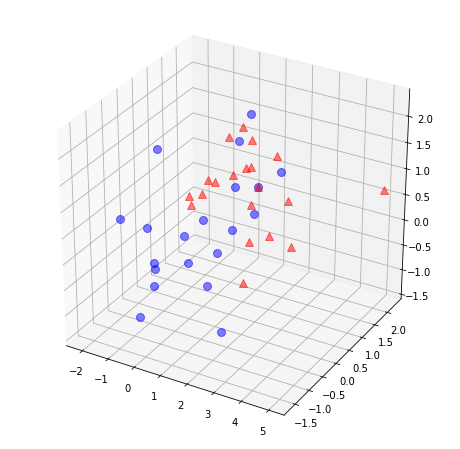

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10

ax.plot(class1_sample[0, :], class1_sample[1, :], class1_sample[2, :],
        'o', markersize=8, color='blue', alpha=0.5, label="Class 1")

ax.plot(class2_sample[0, :], class2_sample[1, :], class2_sample[2, :],
        '^', markersize=8, color='red', alpha=0.5, label="Class 2")

We do not need the class labels for now, so let's merge the data for the two classes

In [ ]:
all_samples = torch.cat([class1_sample, class2_sample], dim = 1)
assert all_samples.shape == (3, 40)

# Computation

In [ ]:
mean_vector = all_samples.mean(dim=1, keepdim=True)
mean_vector

tensor([[-5.5134e-08],
        [-4.4703e-09],
        [ 0.0000e+00]])

Let's now compute the covariance matrix

In [ ]:
#export
def torchCov(matrix:torch.Tensor, transposed=False):
    "Transposed = True if individual samples are columns and not rows"
    if not isinstance(matrix, torch.Tensor): matrix = torch.tensor(matrix)
    m = matrix.T if transposed else matrix
    n = m.shape[0]
    mean = m.mean(axis=0, keepdim=True)
    m.sub_(mean)
    return (m.T @ m) * 1 / (n-1)

In [ ]:
n = all_samples.shape[1]
cov_mat = torchCov(all_samples, True)
np.testing.assert_array_almost_equal(np.cov(all_samples.numpy()), cov_mat.numpy())
cov_mat

tensor([[ 1.6991,  0.4874,  0.4381],
        [ 0.4874,  0.8311, -0.0191],
        [ 0.4381, -0.0191,  1.0352]])

We'll now get the eigen vectors and eigen values

In [ ]:
eig_vals, eig_vecs = cov_mat.eig(True)

In [ ]:
# Checking if the calculations are correct
torch.testing.assert_allclose(cov_mat @ eig_vecs, eig_vecs * eig_vals[:,0])

## Visualizing Eignen Vectors

In [ ]:
#export
from matplotlib.patches import FancyArrowPatch

In [ ]:
#export
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs
        
    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

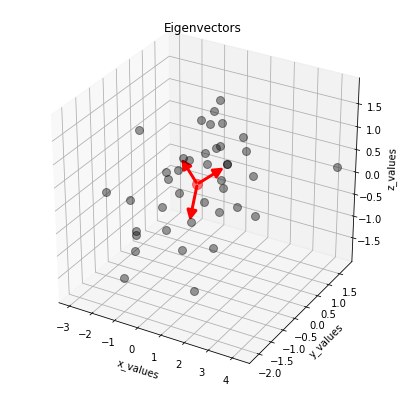

In [ ]:
means = mean_vector
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(all_samples[0,:], all_samples[1,:], all_samples[2,:],
        'o', markersize=8, color='black', alpha=0.4)

ax.plot([means[0].item()], [means[1].item()], [means[2].item()],
        'o', markersize=10, color='red', alpha=0.5)

for v in eig_vecs.T:
    a = Arrow3D([means[0].item(), v[0]], [means[1].item(), v[1]], [means[2].item(), v[2]],
                mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
    
ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Eigenvectors')

plt.show()

### Chossing our top *K* Components

In [ ]:
vals = eig_vals[:, 0] # Ignoring the column with the complex part

In [ ]:
order = vals.argsort(descending=True)
order

tensor([0, 2, 1])

In [ ]:
k = 2
top_k = eig_vecs[:, order[:k]]
top_k

tensor([[ 0.8694, -0.1322],
        [ 0.3364, -0.5472],
        [ 0.3618,  0.8265]])

# Transforming our data into the new space:

In [ ]:
transformed = (all_samples.T @ top_k).T
assert transformed.shape == (k, all_samples.shape[1])

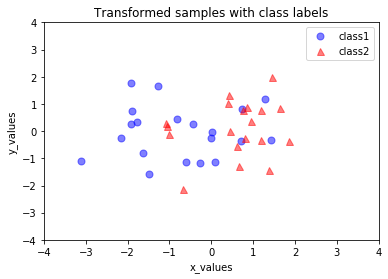

In [ ]:
plt.plot(transformed[0,0:20], transformed[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed[0,20:40], transformed[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples with class labels')

plt.show()

## Compare with sklearn PCA

In [ ]:
#export
from sklearn.decomposition import PCA

In [ ]:
eigs = PCA(n_components=2).fit(all_samples.T).components_

In [ ]:
eigs

array([[ 0.86941384,  0.33644934,  0.36183064],
       [ 0.13222411,  0.54717839, -0.82650625]])

In [ ]:
top_k

tensor([[ 0.8694, -0.1322],
        [ 0.3364, -0.5472],
        [ 0.3618,  0.8265]])

The eigenvectors seem to be identical. This means that our approach is correct

# Packaging everything together

In [ ]:
n = 200
mu1 = torch.tensor([0,0,0]).float()
cov1= torch.eye(3).float()

mu2 = torch.tensor([1,1,1]).float()
cov2= torch.eye(3).float()

class1_sample = torch.distributions.MultivariateNormal(mu1, cov1).sample((n,)).T
class2_sample = torch.distributions.MultivariateNormal(mu2, cov2).sample((n,)).T

assert class1_sample.shape == class2_sample.shape == (3, n)

all_samples = torch.cat([class1_sample, class2_sample], dim = 1)
assert all_samples.shape == (3, n*2)

In [ ]:
labels = torch.zeros(n*2)
labels[:n]   = 0
labels[n:] = 1

In [ ]:
def visualize3dData(matrix:torch.Tensor, labels=None, transposed=False):
    if not isinstance(matrix, torch.Tensor): matrix = torch.tensor(matrix)
    m = matrix.clone().T if not transposed else matrix.clone()
    assert m.shape[0] == 3
    if labels is None:
        labels = torch.zeros(m.shape[1])
    else: 
        if not isinstance(labels, torch.Tensor): labels = torch.tensor(labels)
    
    fig = plt.figure(figsize=(16,16))
    ax = fig.add_subplot(111, projection='3d')
    plt.rcParams['legend.fontsize'] = 10
    
    classes = torch.unique(labels)
    for label in classes:
        data = m[:, labels == label]
        ax.plot(data[0, :], data[1, :], data[2, :],
                'o', markersize=8, alpha=0.6, label="Class 1")
    
    mean_vector = m.mean(dim=1, keepdim=True)
    cov_mat = torchCov(m, True)
    eig_vals, eig_vecs = cov_mat.eig(eigenvectors=True)
    eig_vals = eig_vals[:, 0] # Ignoring the complex part [:, 1]
    scaled_eig_vecs = eig_vecs * eig_vals
    
    means = mean_vector
    for v in scaled_eig_vecs.T:
        a = Arrow3D([means[0].item(), v[0]], [means[1].item(), v[1]], [means[2].item(), v[2]],
                    mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
        ax.add_artist(a)

    ax.set_xlabel('x_values')
    ax.set_ylabel('y_values')
    ax.set_zlabel('z_values')

    plt.title('Eigenvectors')

    plt.show()
    return fig

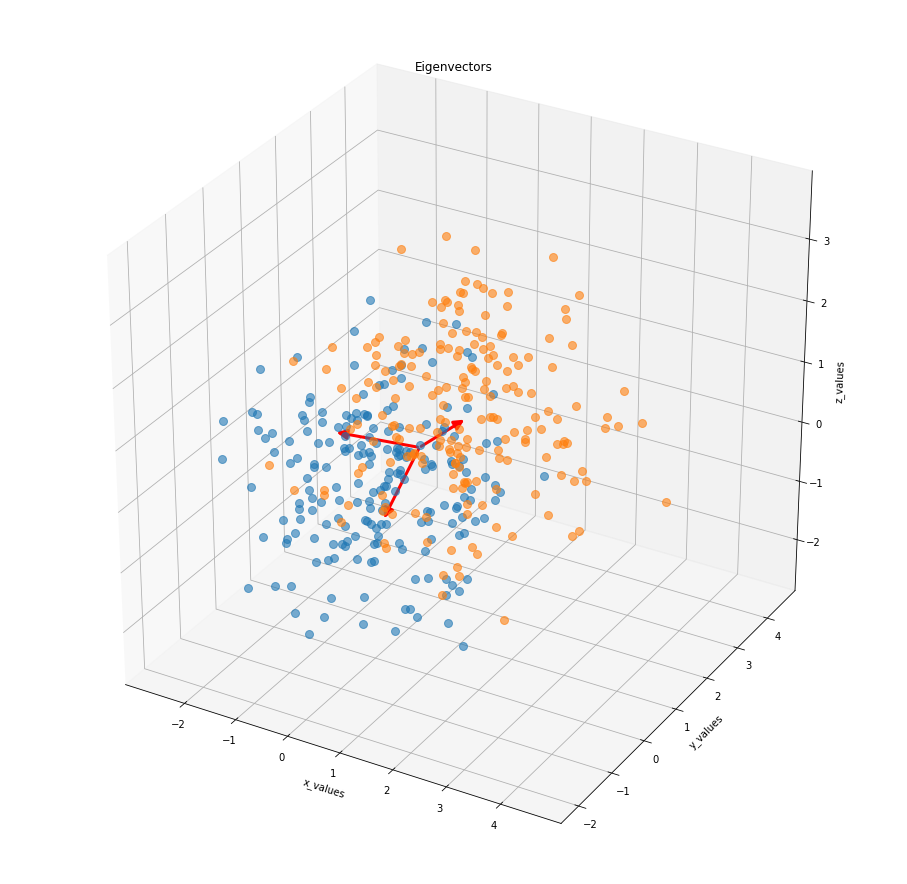

In [ ]:
fig = visualize3dData(all_samples, labels=labels, transposed=True)

In [ ]:
def torchPCA(matrix:torch.Tensor, k=2, transposed=False, fp16=True):
    # Convert to tensor, cuda, half precision
    if not isinstance(matrix, torch.Tensor): matrix = torch.tensor(matrix)
    if torch.cuda.is_available(): 
        if fp16: matrix = matrix.cuda().half()
        else:    matrix = matrix.cuda() 
    
    # Make sure samples are rows and not columns
    m = matrix.T if transposed else matrix
    
    # PCA Computations
    cov_mat = torchCov(m, False)
    eig_vals, eig_vecs = cov_mat.eig(eigenvectors=True)
    eig_vals = eig_vals[:, 0] # Ignoring the complex part [:, 1]
    
    # Getting the top k eigen vectors
    order = eig_vals.argsort(descending=True)
    top_k = eig_vecs[:, order[:k]]
    
    # Reducing the matrix
    return m @ top_k, top_k

In [ ]:
# Testing by comparing with sklean's PCA algorithm

_, eigs = torchPCA(all_samples, transposed=True);
skeigs = PCA(n_components=2).fit(all_samples.T).components_.T
eigs = np.abs(eigs.detach().cpu().numpy())
skeigs=np.abs(skeigs)
np.testing.assert_array_almost_equal(eigs, skeigs)